# W207 Final Project Baseline

- Authors: Christian Millsop, Chris Ventura, Stanley Ye
- Kaggle Project: [Airbnb New User Bookings](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data)
- Github Repo: [w207_final_airbnb](https://github.com/cmventura/w207_final_airbnb)

## Introduction

For this paper, we will use various machine learning models to complete the Airbnb new user bookings Kaggle competition.  This competition was originally designed as a recruiting tool for Airbnb.  The stated goal of this competition is to predict in which country a new user will make their first booking<sup>[1]</sup>.  To complete this challenge, Airbnb and Kaggle have provided several datasets consisting of user demographics, summary statistics, and web session information to try to predict a target variable consisting of the country in which a user made their first booking.  Given that our core problem is to predict where users will make their first booking, we will attempt to answer the following research question: What is the relationship of a user profile and online activity within the Airbnb website to the travel destination?

To answer this question we will optimize and combine several machine learning models to generate accurate destination predictions.  We will be using both derived and raw features from the datasets as inputs to these models.  Using known best practices<sup>[2][3]</sup> to examine the effect of the various features on the end predictions.  This will show both the effectiveness of various models as well as the relative importance of each feature at predicting accurate destinations.  After examination, we will be able to answer our initial research question by identifying which aspects of a user’s profile and online activity have a relationship to the selection of one or more travel destinations.

While we will be optimizing our models to accurately predict the destination country, the Kaggle competition allows for up to five predictions per user.  The competition uses the following Normalized Discounted Cumulative Gain (NDCG) formula to score results<sup>[4]</sup>:

<img src="ndcg_formula.png" align="center"/>

## Dataset Descriptions

### Dataset: age_gender_bkts:

This dataset contains the population, in thousands, aggregated at the following dimensions: year, age bucket, destination country, and gender.

| Column                  | Description                                                                                           |
|-------------------------|-------------------------------------------------------------------------------------------------------|
| age_bucket              | five-year age interval buckets, with a single bucket for 100+                                         |
| country_destination     | the destination country dimension, can be US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', or 'AU' |
| gender                  |  the gender dimension, can be 'male' or 'female'                                                      |
| population_in_thousands | the population for the specific set of dimensions                                                     |
| year                    | the year dimension                                                                                    |

### Dataset: countries

This dataset lists summary information for each possible destination country.

| Column                        | Description                                                                                                           |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| country_destination           | the destination country dimension, can be US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', or 'AU'                 |
| lat_destination               | the latitude of the destination country                                                                               |
| lng_destination               | the longitude of the destination country                                                                              |
| distance_km                   | the distance in kilometers of the country from the United States                                                      |
| distance_km_2                 | unknown                                                                                                               |
| destination_language          | the primary spoken language of the destination country                                                                |
| language_levenshtein_distance | a measure of similarity between the destination_language and English, with a lower number representing a closer match |

### Dataset: sample_submission_NDF

This dataset contains the Kaggle submission format, consisting of the user ID and destination country.  According to the competition documentation, there can be up to five entries per user ID, with the lower index rank being the higher choice, which impacts the ultimate score returned in the scoring formula.

| Column  | Description                       |
|---------|-----------------------------------|
| id      | the user id                       |
| country | the predicted destination country |

### Dataset: sessions

This dataset contains user session data, broken out by user action.  This data will be used to examine if user behavior patterns can be indicative of the user’s end destination choice.

| Column        | Description                                               |
|---------------|-----------------------------------------------------------|
| user_id       | the user id, used to connect to other datasets            |
| action        | the action taken by the user                              |
| action_type   | the category of the action                                |
| action_detail | further detail of the action                              |
| device_type   | the device on which the user performed the action         |
| secs_elapsed  | the time elapsed between this action and the prior action |

### Dataset: train_users_2

his dataset contains the user id, target variable of destination country, as well as demographic and account detail information.

| Column                  | Description                                                                        |
|-------------------------|------------------------------------------------------------------------------------|
| id                      | the user id, used to connect to other datasets                                     |
| date_account_created    | the date on which the user first created the account                               |
| timestamp_first_active  | the the timestamp of when the user was first active, can predate account creation  |
| date_first_booking      | the date of the user's first booking, will be 'NaN' in event the user did not book |
| gender                  | the gender of the user, if known                                                   |
| age                     | the age of the user, if known                                                      |
| signup_method           | the user's method for account signup                                               |
| signup_flow             |                                                                                    |
| language                | the user's selected language                                                       |
| affiliate_channel       | indicates the channel through which the user was directed to the website           |
| affiliate_provider      | indicates the provider of the channel, if applicable                               |
| first_affiliate_tracked | indicates the first affiliate through which the user was tracked, if applicable    |
| signup_app              | indicates which app the user used to create an account                             |
| first_device_type       | indicates the first device identified for the user                                 |
| first_browser           | indicates the first browser identified for the user                                |
| country_destination     | the target variable; the ultimate destination selection by the user                |

## Description of Approach

[Initial Pipeline]

## Setup and Data Cleaning

### Import Libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

### Data files from Kaggle

We will be exploring each of the data files in turn.  The below code will load all of the data files as data frames into a dictionary and then made a copy of that dictionary.  One of the dictionaries will be used as our raw representation of the data whereas the other will be the final, cleaned representation.  This is to prevent mutation of the data and allow error-free, partial re-execution of this notebook.

In [3]:
DATA_PATH = './data/extracted'
dfs_raw = {}
dfs = {}
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        dfs_raw[file.split('.')[0]] = pd.read_csv(f'{DATA_PATH}/{file}')
        dfs = dfs_raw.copy()
        print(file)

age_gender_bkts.csv
countries.csv
sample_submission_NDF.csv
sessions.csv
test_users.csv
train_users_2.csv


## Dataset: age_gender_bkts

Description: This file contains demographic information for each of the possible destination countries.  The demographics are bucketed into age ranges with gender and population count by year.

Relevance: Demographic information of the destination of the destination country might be correlated to the the gender and age of the user.

In [4]:
dfs_raw['age_gender_bkts'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


Change the coding on 'year' to ensure that it is represented properly in our analyses.

In [5]:
dfs['age_gender_bkts'].year = dfs_raw['age_gender_bkts'].year.astype(int)

In [6]:
dfs['age_gender_bkts'].head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015
1,95-99,AU,male,9.0,2015
2,90-94,AU,male,47.0,2015
3,85-89,AU,male,118.0,2015
4,80-84,AU,male,199.0,2015


## Dataset: countries

Description: Information about the destination countries, including the location and language spoken at each of the countries as well as the distance of the location and language compared to the USA (origin country).  The language codes need to be modified in order to match with the language codes used in the user datasets.

Relevance:
+ Countries may be clustered by similarity to each other and by dissimilarity to the origin country.
+ Specific characteristics of the traveler and destination might have a correlation.

In [7]:
dfs_raw['countries'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


In [8]:
dfs['countries']

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


Modify the language codes so that they match with the user datasets.

In [9]:
dfs['countries']['destination_language '] = pd.Series(['en', 'en', 'de', 'es', 'fr', 'en', 'it', 'nl', 'pt', 'en'])

## Dataset: sample_submission_NDF

Description: The results of our analysis should match the format of this file.

Relevance: This is not relevant to the analysis.

In [10]:
dfs['sample_submission_NDF'].head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


## Dataset: sessions

Description: User session data on the Airbnb website.  A session is a sequence of actions performed on the website.
+ secs_elapsed = The amount of time between that action and the prior action.
+ There is no session_id column and some of the secs_elapsed columns are extremely long.  We will assume that all visits to Airbnb are aggregated into a single session per user.  The large secs_elapsed are the intervals between user visits to Airbnb.
+ The dataset does not tell us what searches the user performed (ie. related to a destination), only that a user was searching or interacting with the Airbnb platform in some way.
+ device_type = Device that the user performed the action from
 + If the device changes over time is the user more engaged in making a booking through AirBnB?

Relevance:
+ It's hard to pinpoint the "hard" relevance of this dataset.  It could be used to develop an understanding of user interest/engagement or to identify whether a user has specific concerns/requirements related to their destination.
+ Some actions appear interesting: "view_ghosting_reasons", "special_offer_field", "airbnb_picks_wishlists"

In [11]:
dfs_raw['sessions'].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          10533241 non-null object
action           10488111 non-null object
action_type      9441533 non-null object
action_detail    9441533 non-null object
device_type      10567737 non-null object
secs_elapsed     10431706 non-null float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


Clean the 34,496 null user_id's since the sessions data can't be joined to the users data without it.

In [12]:
dfs['sessions'] = dfs_raw['sessions'].dropna(subset=['user_id'])

In [13]:
dfs['sessions'].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## Dataset: train_users_2

Description: This dataset contains the main training data.  Each row is a user profile and contains basic information as well the chosen destination.
+ date_first_booking has NaN values. We'll accept these into the dataset since they correspond to NDF destinations.
+ first_affiliate_tracked also has a significant number of NaN.
+ Age has bad values as well as NaN.  The NaN we will leave in since they comprise a significant portion of our training set and we expect that to be representative of real data that we encounter.  Our classifier should be capable of predicting users with NaN age.

Relevance: We will join the other datasets into this one on id and country.

In [14]:
dfs_raw['train_users_2'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [15]:
dfs['train_users_2'].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### Cleaning: age

The oldest person in the world was 122 year old.  Our dataset contains 781 entries where the age is >122 years old.  Realistically we don't expect there to be many people anywhere near 122 years old since this is a travel and ecommerce dataset, but we can't rule out the possibility.

Likewise, the minimum age to use Airbnb is 18.  There are 158 users in our dataset with an age less than that.

In [16]:
dfs_raw['train_users_2'].query('age > 122').age.count()

781

In [17]:
dfs_raw['train_users_2'].query('age <18').age.count()

158

In [18]:
dfs['train_users_2'] = dfs['train_users_2'][(dfs['train_users_2'].age.isnull()) | ((dfs['train_users_2'].age < 122) & (dfs['train_users_2'].age >=18))]

### Cleaning: Date Account Created

29 accounts have the date_first_booking before the date_account_created.  These should be excluded.

In [19]:
dfs_raw['train_users_2'].query('date_account_created > date_first_booking').id.count()

29

In [20]:
dfs['train_users_2'].loc[:,'date_first_booking'] = pd.to_datetime(dfs_raw['train_users_2'].date_first_booking, format='%Y-%m-%d', errors='coerce')
dfs['train_users_2'].loc[:,'date_account_created'] = pd.to_datetime(dfs_raw['train_users_2'].date_account_created, format='%Y-%m-%d', errors='coerce')

C:\Users\sye\AppData\Local\Continuum\anaconda3\envs\mids-w203\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
dfs['train_users_2'] = dfs['train_users_2'][(dfs['train_users_2'].date_first_booking.isnull()) | (dfs['train_users_2'].date_account_created <= dfs['train_users_2'].date_first_booking)]

### Cleaning: timestamp_first_active

178 rows have a timestamp_first_active > date_account_created.  Since timestamp_first_active seems to indicate the first time that a user was tracked on Airbnb (before creating an account), we'll omit the relatively few rows where this doesn't hold true.

In [22]:
(pd.to_datetime(dfs_raw['train_users_2'].date_account_created, format='%Y-%m-%d', errors='coerce') < pd.to_datetime(dfs_raw['train_users_2'].timestamp_first_active,format='%Y%m%d%H%M%S')).value_counts()

True     213273
False       178
dtype: int64

In [23]:
dfs['train_users_2']['delta_creation_active'] = dfs['train_users_2']['date_account_created'] - pd.to_datetime(dfs['train_users_2'].timestamp_first_active,format='%Y%m%d%H%M%S')

In [24]:
dfs['train_users_2'] = dfs['train_users_2'][dfs['train_users_2'].delta_creation_active <= pd.Timedelta('0 sec')]

## Exploratory Data Analysis

### Univariate exploration

Observations
+ age-gender-bkts
  + The age_bucket is top-coded at 100+
  + All data is for the year 2015.  If we use this data for analysis then we need to assume that the demographic trends hold for all yeears in our user dataset.
+ train_user_2
  + A significant number of gender values are non-binary.  We should be careful to transform the gender column into separate categorical features for each of the options.
  + ~half of the dataset did not choose a destination, most of the rest went to the US.  This will make it difficult to identify if people are going to specific foreign countries since the data related to those outcomes is relatively limited.

In [25]:
dfs['age_gender_bkts'].describe(include='all')

,age_bucket,country_destination,gender,population_in_thousands,year
count,420,420,420,420.000000,420.0
unique,21,10,2,NaN,NaN
top,45-49,NL,female,NaN,NaN
freq,20,42,210,NaN,NaN
mean,NaN,NaN,NaN,1743.133333,2015.0
std,NaN,NaN,NaN,2509.843202,0.0
min,NaN,NaN,NaN,0.000000,2015.0
25%,NaN,NaN,NaN,396.500000,2015.0
50%,NaN,NaN,NaN,1090.500000,2015.0
75%,NaN,NaN,NaN,1968.000000,2015.0


In [26]:
dfs['age_gender_bkts'].describe(include='all')

,age_bucket,country_destination,gender,population_in_thousands,year
count,420,420,420,420.000000,420.0
unique,21,10,2,NaN,NaN
top,45-49,NL,female,NaN,NaN
freq,20,42,210,NaN,NaN
mean,NaN,NaN,NaN,1743.133333,2015.0
std,NaN,NaN,NaN,2509.843202,0.0
min,NaN,NaN,NaN,0.000000,2015.0
25%,NaN,NaN,NaN,396.500000,2015.0
50%,NaN,NaN,NaN,1090.500000,2015.0
75%,NaN,NaN,NaN,1968.000000,2015.0


In [27]:
dfs['sessions'].describe(include='all')

,user_id,action,action_type,action_detail,device_type,secs_elapsed
count,10533241,10453761,9410284,9410284,10533241,1.039776e+07
unique,135483,359,10,155,14,NaN
top,mxqbh3ykxl,show,view,view_search_results,Mac Desktop,NaN
freq,2722,2758985,3549375,1771026,3585886,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.941124e+04
std,NaN,NaN,NaN,NaN,NaN,8.890920e+04
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,2.290000e+02
50%,NaN,NaN,NaN,NaN,NaN,1.146000e+03
75%,NaN,NaN,NaN,NaN,NaN,8.442000e+03


In [28]:
dfs['train_users_2'].describe(include='all')

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,delta_creation_active
count,212336,212336,2.123360e+05,88387,212336,124367.000000,212336,212336.000000,212336,212336,212336,206331,212336,212336,212336,212336,212336
unique,212336,1633,NaN,1976,4,NaN,3,NaN,25,8,18,7,4,9,52,12,NaN
top,fm5cv0kfbp,2014-05-13 00:00:00,NaN,2014-05-22 00:00:00,-unknown-,NaN,basic,NaN,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN
freq,1,671,NaN,247,95573,NaN,152068,NaN,205261,137041,136745,108706,181692,89147,63526,123949,NaN
first,NaN,2010-01-01 00:00:00,NaN,2010-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2014-06-30 00:00:00,NaN,2015-06-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.013088e+13,NaN,NaN,37.440261,NaN,3.273722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1 days +11:15:26.392533
std,NaN,NaN,9.231791e+09,NaN,NaN,13.933221,NaN,7.646294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 08:04:01.427727
min,NaN,NaN,2.010010e+13,NaN,NaN,18.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1 days +00:00:01
25%,NaN,NaN,2.012123e+13,NaN,NaN,28.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1 days +03:50:46


In [29]:
dfs['train_users_2']['gender'].value_counts()

-unknown-    95573
FEMALE       62417
MALE         54070
OTHER          276
Name: gender, dtype: int64

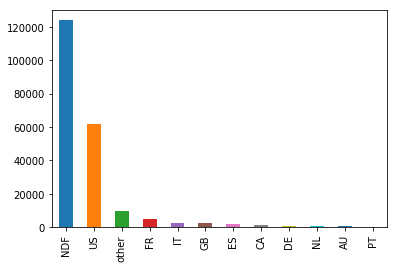

In [30]:
dfs['train_users_2'].country_destination.value_counts().plot.bar()

In [31]:
dfs['train_users_2'].age.describe()

count    124367.000000
mean         37.440261
std          13.933221
min          18.000000
25%          28.000000
50%          34.000000
75%          43.000000
max         115.000000
Name: age, dtype: float64

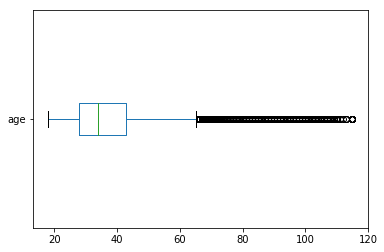

In [32]:
dfs['train_users_2'].age.plot.box(vert=False)

### Multivariate exploration

Observations:
+ unknown gender and NDF are highly correlated
+ When a destination_country speaks the same language as the user, there is an increased probability that the user will go to that country.  However, users overwhelming are going to english speaking destinations, regardless of their chosen language.
+ When a user is young, they are more likely to be female, whereas when they are older, there is equal probability of male or female.

Gender and country destination

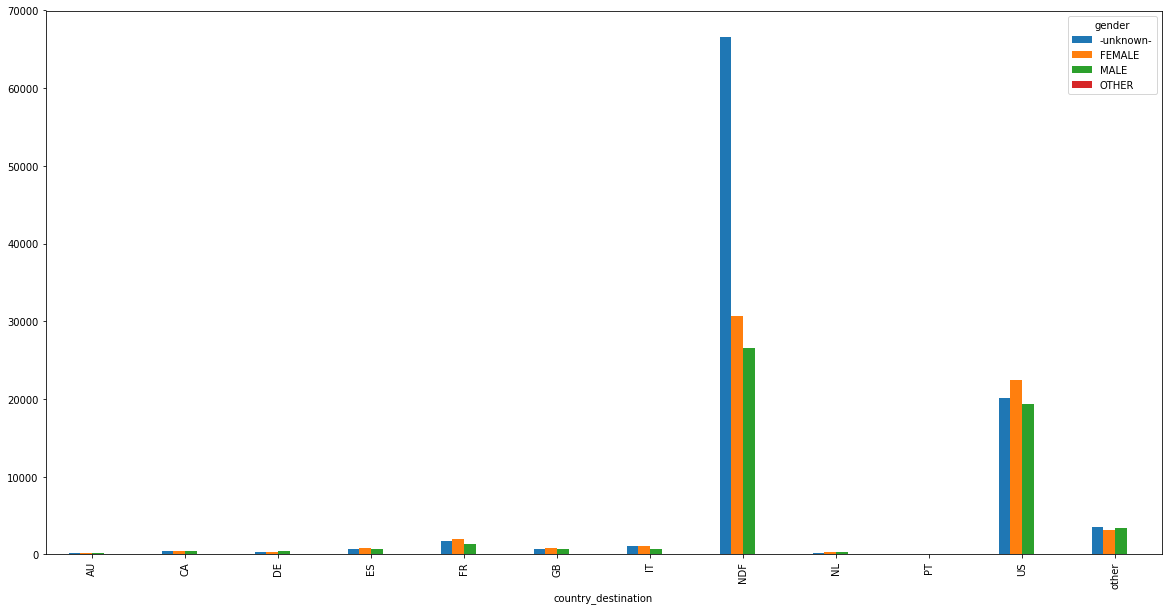

In [33]:
plt.rcParams['figure.figsize'] = [20, 10]
pd.crosstab(dfs['train_users_2']['country_destination'],dfs['train_users_2']['gender']).plot.bar()

User language and language at destination (excluding language)

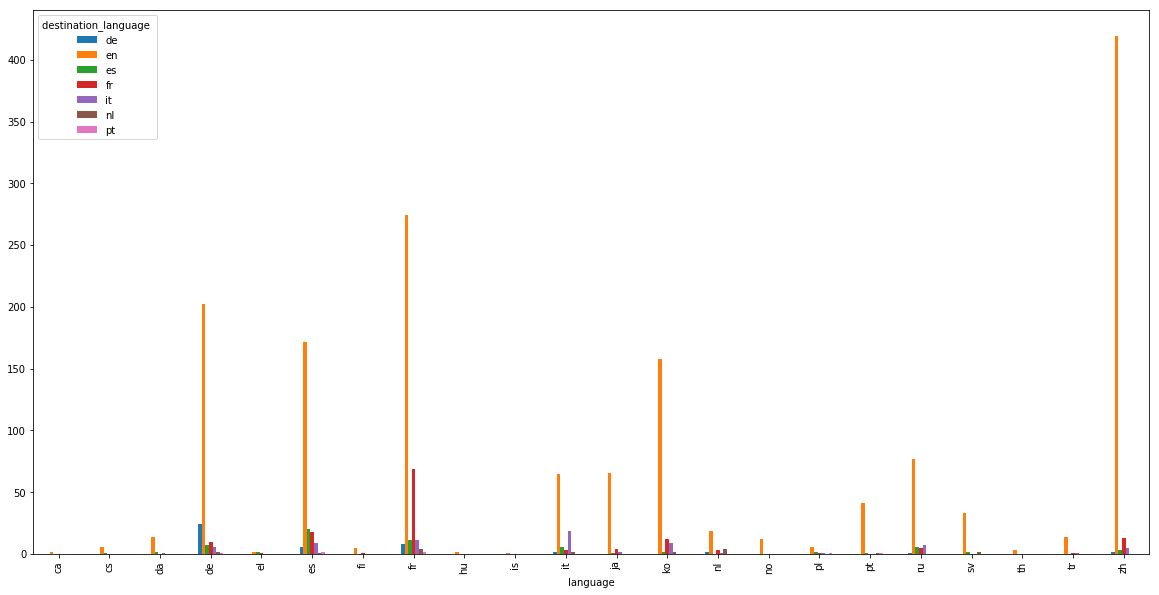

In [34]:
joined_country = dfs['train_users_2'].join(dfs['countries'].set_index('country_destination'), on='country_destination')
joined_country_no_english = joined_country[joined_country['language'] != 'en']
plt.rcParams['figure.figsize'] = [20, 10]
ct = pd.crosstab(joined_country_no_english['language'],joined_country_no_english['destination_language ']).plot.bar()

Age and gender among users

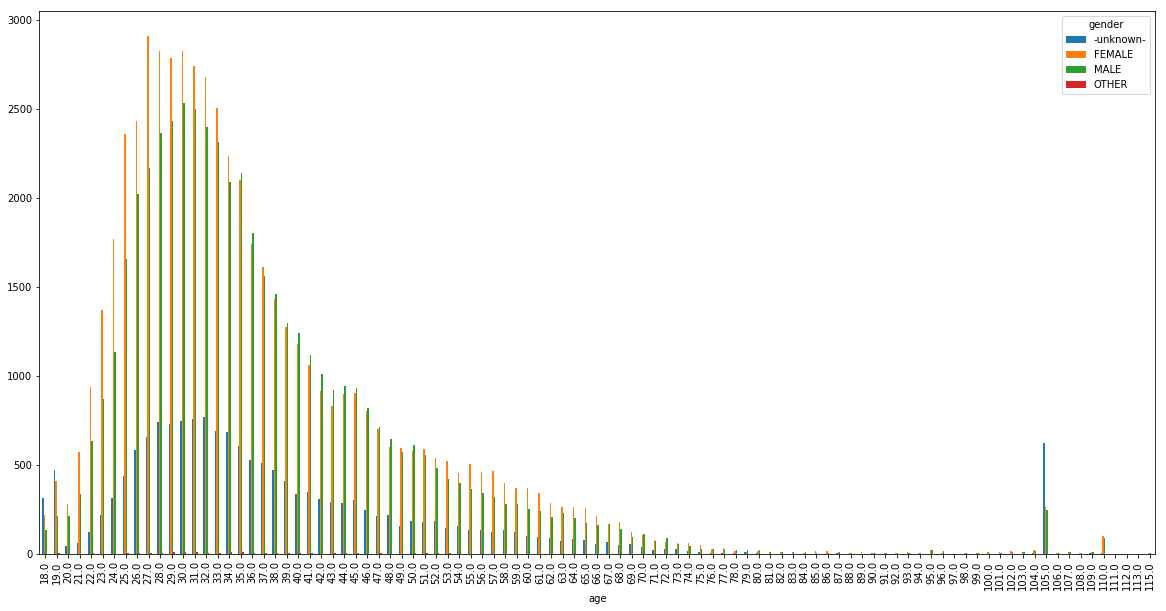

In [35]:
pd.crosstab(dfs['train_users_2']['age'],dfs['train_users_2']['gender']).plot.bar()